In [7]:
import pandas as pd
import ccxt
import time
from timeit import default_timer as timer
from matplotlib import pyplot
from decimal import Decimal as D
import numpy as np
from tqdm import tqdm_notebook, tqdm
from tqdm import tnrange as trange

In [2]:
this_exchange = ccxt.poloniex()

In [3]:
if False:
    for i in POLO.__dict__:
        if '__' not in i:
            if 'fetch' in i:
                print(i)

In [4]:
ticker = this_exchange.fetchTickers()

In [5]:
x = list(ticker)[0]
print(x)

BCN/BTC


In [9]:
coins_not_working = ['LTC/BTC', 'STR/BTC']
coins_to_use = ['ETH/BTC', 'XRP/BTC', 'DASH/BTC' , 'XMR/BTC',
                'BTS/BTC', 'DOGE/BTC', 'FCT/BTC', 'MAID/BTC', 'CLAM/BTC']
coins_collected = []
datasets = []
min_len = 10000000
start_data_gen = timer()
amount_of_coins = len(ticker)
# for index, pair in enumerate(ticker):
for index in trange(amount_of_coins):
    pair = list(ticker)[index]
    if pair in coins_to_use:
        if pair not in coins_collected:
            print(pair)
            # SLEEP!! DO NOT GET BANNED!
            time.sleep (this_exchange.rateLimit / 400)
            start_call = timer()
            chart = this_exchange.fetchOhlcv(pair, 
                                             timeframe = '5m', # polo only offers the 5m
                                             since = int(1515974400)
                                             )
            df = pd.DataFrame(
                chart, 
                columns=['time','open','high','low','close','vol']
            )
            df.pair = pair
            this_len = len(df)
            if this_len < min_len:
                min_len = this_len
            tqdm.write('Elements in Dataset: {}'.format(this_len))
            tqdm.write('Downloading this coin took: {:.2f} secs'.format(timer()-start_call))
            datasets.append(df)
            coins_collected.append(pair)
print('Min length of all sets is {} samples'.format(min_len))
print('Collected All Datasets. Took {:.2f} mins'.format(float(timer()-start_data_gen)/60))        

HBox(children=(IntProgress(value=0, max=99), HTML(value='')))

BTS/BTC
Elements in Dataset: 364114
CLAM/BTC
Elements in Dataset: 376195
DASH/BTC
Elements in Dataset: 418608
DOGE/BTC
Elements in Dataset: 423478
MAID/BTC
Elements in Dataset: 374885
XMR/BTC
Elements in Dataset: 389703
XRP/BTC
Elements in Dataset: 364666
ETH/BTC
Elements in Dataset: 261259
FCT/BTC
Elements in Dataset: 244616
Min length of all sets is 244616 samples
Collected All Datasets. Took 1.81 mins


In [10]:
# the end time in all datasets is the same... so take the min_len to the end
new_datasets = []
for d in datasets:
    pair = d.pair
    this_len = len(d)
    print(pair, this_len)
    if this_len == min_len:
        print('this is the lowest len df and not changing')
        time_of_start = d['time'][0]
        time_of_end = d['time'][len(d['time'])-1]
        new_datasets.append(d) 
    elif this_len > min_len:
        trim_section_start = len(d['time']) - min_len
        time_of_start = d['time'][trim_section_start]
        time_of_end = d['time'][len(d['time'])-1]
        df = d[trim_section_start:]
        df.pair = pair
        new_datasets.append(df)    
    print('Start of set {}'.format(time_of_start))
    print('end of set {}'.format(time_of_end))
    print('New set len {}'.format(len(df)))
    

BTS/BTC 364114
Start of set 1444003500000
end of set 1517388000000
New set len 244616
CLAM/BTC 376195
Start of set 1444003200000
end of set 1517387700000
New set len 244616
DASH/BTC 418608
Start of set 1444003200000
end of set 1517387700000
New set len 244616
DOGE/BTC 423478
Start of set 1444003500000
end of set 1517388000000
New set len 244616
MAID/BTC 374885
Start of set 1444003500000
end of set 1517388000000
New set len 244616
XMR/BTC 389703
Start of set 1444003500000
end of set 1517388000000
New set len 244616
XRP/BTC 364666
Start of set 1444003500000
end of set 1517388000000
New set len 244616
ETH/BTC 261259
Start of set 1444003500000
end of set 1517388000000
New set len 244616
FCT/BTC 244616
this is the lowest len df and not changing
Start of set 1444003200000
end of set 1517387700000
New set len 244616


In [11]:
for set_ in new_datasets:
    print(set_.pair, len(set_))

BTS/BTC 244616
CLAM/BTC 244616
DASH/BTC 244616
DOGE/BTC 244616
MAID/BTC 244616
XMR/BTC 244616
XRP/BTC 244616
ETH/BTC 244616
FCT/BTC 244616


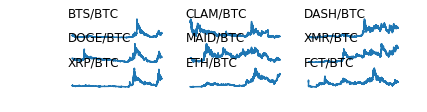

In [12]:
pyplot.figure()
i = 1
for set_ in new_datasets:
    pyplot.subplot(len(new_datasets), 3, i)
    pyplot.plot(set_['close'])
    pyplot.axis('off')
    pyplot.title(set_.pair, y=.75, loc='left')
    i += 1
pyplot.show()

In [ ]:
# WHAT DO I WANT FOR COLUMNS!?!?!?!?!
# Each input will have 20 values
# input1 = [[last][vol][last -60 elements]]
# input2 = [[low][high][mean*]]
# input3 = [[bollinger high][bollinger low][mean**]]
# ###
# input4 = [[twitter sent][twittervol]]
# ###
# output1 = [time, time+1, time+2] # doesnt matter what the input all the outputs will be the same and averaged over

In [ ]:
for set_ in new_datasets:
    print(set_.pair)

In [ ]:
cols = []
for i in range(60):
    cols.append('close_{}'.format(i))
    cols.append('vol_{}'.format(i))
print(cols)

In [ ]:
working_df = pd.DataFrame(columns=cols)

In [ ]:
# input1 = [[last][vol][1]]
dataset = np.zeros((2, 60, len(new_datasets), len(new_datasets[0])))
for index1, set_ in enumerate(new_datasets):
    set_for_all_coins = []
    for index2 in range(len(set_)):
        set_of_elements = []
        if index2 <= len(set_) - 60:
            elements = []
            for i in range(60):
                close = set_.loc[i + index2]['close']
                vol = set_.loc[i + index2]['vol']
                elements.append(close)
                elements.append(vol)
            set_of_elements.append(elements)
        set_for_all_coins.append(set_of_elements)
    dataset.append(set_for_all_coins, index1)
            


In [ ]:
fakeset = np.zeros((2, 60, 9, len(new_datasets[0]) - 60))

In [ ]:
x = new_datasets[0].loc[200000]['close']

In [17]:
start_time = timer()
# num of max rows is the num of max elements in any dataset
set_len = len(new_datasets[0]) - 60
everything = []
for index in trange(3333,
                   ascii=True,
                            desc="OneRow",
                            # dynamic_ncols=True,
                            smoothing=0,
                            leave=False,
                            # unit_scale=True
                   ):
    # each row has all the coins
    coins = []
    """
    for coin_range in trange(len(new_datasets),
                            ascii=True,
                            desc="coin",
                            # dynamic_ncols=True,
                            smoothing=1,
                            leave=False,
                            # unit_scale=True
                            ): """
    for coin_range in range(len(new_datasets)):
        coin = new_datasets[coin_range]
        cols = coin.columns
        coin = pd.DataFrame(coin, columns=cols)
        # need 60 elements for each frame of the master time index
        elements = []
        """
        for element_range in trange(60,
                                   ascii=True,
                                    desc="inner",
                                    # dynamic_ncols=True,
                                    smoothing=1,
                                    leave=False,
                                    # unit_scale=True
                                   ): """
        for element_range in range(60):
            # get the 2 things we need.
            close = coin.loc[int(len(new_datasets[0])-int(index+element_range))-1]['close']
            vol = coin.loc[int(len(new_datasets[0])-int(index+element_range))-1]['vol']
            elements.append([close, vol])
        coins.append(elements)
        
    if index % 1000 == 0:
        tqdm.write('Completed {} of {} rows of data... LOLZ..'.format(index, set_len))
        tqdm.write('Wow right... this has been running for {:.2f} mins.'.format(float(timer()-start_time)/60))
    everything.append(coins)

HBox(children=(IntProgress(value=0, description='OneRow', max=3333), HTML(value='')))

Completed 0 of 244556 rows of data... LOLZ..
Wow right... this has been running for 0.00 mins.
Completed 100 of 244556 rows of data... LOLZ..
Wow right... this has been running for 0.19 mins.
Completed 200 of 244556 rows of data... LOLZ..
Wow right... this has been running for 0.38 mins.
Completed 300 of 244556 rows of data... LOLZ..
Wow right... this has been running for 0.57 mins.
Completed 400 of 244556 rows of data... LOLZ..
Wow right... this has been running for 0.76 mins.
Completed 500 of 244556 rows of data... LOLZ..
Wow right... this has been running for 0.95 mins.
Completed 600 of 244556 rows of data... LOLZ..
Wow right... this has been running for 1.14 mins.
Completed 700 of 244556 rows of data... LOLZ..
Wow right... this has been running for 1.33 mins.
Completed 800 of 244556 rows of data... LOLZ..
Wow right... this has been running for 1.52 mins.
Completed 900 of 244556 rows of data... LOLZ..
Wow right... this has been running for 1.71 mins.
Completed 1000 of 244556 rows of

In [18]:
x = np.array(everything)

In [19]:
print(x.shape)

(3333, 9, 60, 2)


In [20]:
filename = 'testset.npy'
np.save(filename, x)

In [21]:
y = np.load(filename)

In [23]:
print(x.shape, y.shape)

(3333, 9, 60, 2) (3333, 9, 60, 2)


In [24]:
import tensorflow as tf

In [ ]:
"""

PHONE DIED... BACK IN 5...

is that what you meant by backwards?????????????

.... getting more coffeee....

"""











In [ ]:
df = new_datasets[2]

In [ ]:
print(df.columns)

In [ ]:
close = pd.Series(df['close'])

In [ ]:
raw_values = close.values
print(raw_values)

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        # print(i - interval)
        value = D(dataset[i]) - D(dataset[i - interval])
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[interval-1]

def undiff(dataset, diff, interval=1):
    the_return = list()
    for i, e in enumerate(diff):
        if i >= interval:
            last_val = dataset[i-interval]
            next_val = D(last_val) + D(diff[i])
            # assert next_val == dataset[i]
            the_return.append(next_val)
    return pd.Series(the_return)

In [ ]:
diff_series = difference(close, 1)

In [ ]:
fixed_series = undiff(close, diff_series, 1)

In [ ]:
print(fixed_series.head())

In [ ]:
inverted = list()
for i in range(len(diff_series)):
    value = inverse_difference(close, diff_series[i], len(diff_series)-i)
    inverted.append(value)
inverted = pd.Series(inverted)

In [ ]:
print(close.head())
print(diff_series.head())
print(inverted.head())